## Full Pipeline Notebook

This notebook contains the complete workflow used to generate all results
reported in the paper. It includes:

- Stage A: training the R-GCN encoder and DistMult scoring module,
- Stage B: training the evidential (EPN) head for uncertainty estimation,
- Inference and evaluation pipelines for link prediction,
- Analysis cells for generating tables, plots, and case studies used in the
  figures, main paper, and supplementary materials.

This is the canonical version of the notebook used for the final report,
poster, and paper preparation.


In [1]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda"

g_cpu  = torch.Generator(device='cpu')
g_cuda = torch.Generator(device='cuda')

g_cpu.manual_seed(seed)
g_cuda.manual_seed(seed)


In [2]:
path = "datasets/final_graph.pkl"

with open(path, "rb") as f:
    G = pickle.load(f)

n = G["n_total"]

print("nodes:", n)
print("CC:", len(G["CC"]))
print("CD:", len(G["CD"]))
print("CG:", len(G["CG"]))
print("DD:", len(G["DD"]))


nodes: 2745
CC: 1311830
CD: 4338
CG: 4338
DD: 41


In [3]:
K = 15

M = torch.tensor(G["similarity_matrix"], dtype=torch.float32)
n_circ = G["n_circ"]

new_CC = []
for i in range(n_circ):
    sims = M[i].clone()
    sims[i] = -1e9
    vals, idx = torch.topk(sims, K)
    for j, w in zip(idx.tolist(), vals.tolist()):
        new_CC.append((i, j, float(w)))

print("old CC edges:", len(G["CC"]))
print("new CC edges:", len(new_CC))

G["CC"] = new_CC

old CC edges: 1311830
new CC edges: 21600


In [4]:
rel_map = {"CC": 0, "CD": 1, "CG": 2, "DD": 3}

E_u = []
E_v = []
E_r = []
E_w = []

for (u, v, w) in G["CC"]:
    E_u.append(u)
    E_v.append(v)
    E_r.append(rel_map["CC"])
    E_w.append(w)

for (u, v, w) in G["CD"]:
    E_u.append(u)
    E_v.append(v)
    E_r.append(rel_map["CD"])
    E_w.append(w)

for (u, v, w) in G["CG"]:
    E_u.append(u)
    E_v.append(v)
    E_r.append(rel_map["CG"])
    E_w.append(w)

for (u, v) in G["DD"]:
    E_u.append(u)
    E_v.append(v)
    E_r.append(rel_map["DD"])
    E_w.append(1.0)

E_u = torch.tensor(E_u, dtype=torch.long)
E_v = torch.tensor(E_v, dtype=torch.long)
E_r = torch.tensor(E_r, dtype=torch.long)
E_w = torch.tensor(E_w, dtype=torch.float32)

print("edges:", E_u.shape[0])


edges: 30317


In [5]:
E_u = torch.cat([E_u, E_v.clone()])
E_v = torch.cat([E_v, E_u[:E_v.shape[0]].clone()])
E_r = torch.cat([E_r, E_r.clone()])
E_w = torch.cat([E_w, E_w.clone()])

print("edges with inverse:", E_u.shape[0])


edges with inverse: 60634


In [6]:
n_total = G["n_total"]

t = torch.zeros(n_total, dtype=torch.long)
t[G["n_circ"]: G["n_circ"] + G["n_dis"]] = 1
t[G["n_circ"] + G["n_dis"]:] = 2

d = 64
type_emb = nn.Embedding(3, d)
x = type_emb(t)

x.shape


torch.Size([2745, 64])

In [7]:
CD_pos = torch.tensor([(u, v) for (u, v, _) in G["CD"]], dtype=torch.long)
num_pos = CD_pos.shape[0]

perm = torch.randperm(num_pos, generator=g_cpu)
n_train = int(0.70 * num_pos)
n_val   = int(0.15 * num_pos)
n_test  = num_pos - n_train - n_val

CD_train = CD_pos[perm[:n_train]]
CD_val   = CD_pos[perm[n_train:n_train+n_val]]
CD_test  = CD_pos[perm[n_train+n_val:]]

print("train:", CD_train.shape[0])
print("val:",   CD_val.shape[0])
print("test:",  CD_test.shape[0])


train: 3036
val: 650
test: 652


## Stage A - R-GCN Training (Encoder + DistMult Scoring)

This stage trains a two-layer relational graph convolutional network (R-GCN)
to produce node embeddings for circRNAs, diseases, and genes.  
The implementation below follows the formulation described in the paper:

- Each relation type has its own transformation matrix,
- Messages are normalized by node degrees,
- Two stacked layers produce the final embedding matrix \( Z \).

A DistMult decoder is then trained **on the same embeddings** to score
circRNA–disease pairs. Unlike the end-to-end model (where DistMult is used
only inside the encoder training loop), here DistMult is trained **as a
separate link-prediction head**. This setup ensures that:

- the DistMult-Probe and EPN heads operate on **identical frozen embeddings**,  
- both heads receive the same training examples and negatives,  
- their AUROC/AUPR performance is **directly comparable**,  
- the comparison isolates the scoring function rather than encoder behavior.

This makes Stage A the reference point for our deterministic baseline.


In [8]:
class RGCNLayer(nn.Module):
    def __init__(self, d_in, d_out, num_rel):
        super().__init__()
        self.W = nn.Parameter(
            torch.randn(num_rel, d_in, d_out, generator=g_cpu) * 0.02
        )

    def forward(self, x, E_u, E_v, E_r):
        N = x.size(0)
        out = torch.zeros(N, self.W.size(-1), device=x.device)

        deg = torch.zeros(N, device=x.device)
        deg.index_add_(0, E_v, torch.ones_like(E_v, dtype=torch.float))
        deg = deg.clamp(min=1.0)

        for r in range(self.W.size(0)):
            mask = (E_r == r)
            if not mask.any():
                continue

            u = E_u[mask]
            v = E_v[mask]

            msg = x[u] @ self.W[r]

            scale = 1.0 / torch.sqrt(deg[u] * deg[v])
            msg = msg * scale.unsqueeze(1)

            out.index_add_(0, v, msg)

        return out


class RGCNEncoder(nn.Module):
    def __init__(self, d_in, d_hid, d_out, num_rel, n_layers=2):
        super().__init__()
        dims = [d_in] + [d_hid] * (n_layers - 1) + [d_out]
        self.layers = nn.ModuleList([
            RGCNLayer(dims[i], dims[i+1], num_rel)
            for i in range(n_layers)
        ])

    def forward(self, x, E_u, E_v, E_r):
        for layer in self.layers:
            x = layer(x, E_u, E_v, E_r)
        return x


In [9]:
class DistMult(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.r = nn.Parameter(torch.randn(d, generator=g_cpu) * 0.02)
    def forward(self, zu, zv):
        return (zu * self.r * zv).sum(dim=-1)


class LPModel(nn.Module):
    def __init__(self, enc, d):
        super().__init__()
        self.enc = enc
        self.scorer = DistMult(d)

In [10]:
enc = RGCNEncoder(64, 64, 64, num_rel=4, n_layers=2).to(device)
model = LPModel(enc, 64).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()


In [11]:
CD_set = set((int(u), int(v)) for u, v, _ in G["CD"])

def sample_neg(batch_size, n_circ, n_dis, device="cuda"):

    u = torch.randint(0, n_circ, (batch_size,), device=device, generator=g_cuda)
    v = torch.randint(n_circ, n_circ + n_dis, (batch_size,), device=device, generator=g_cuda)

    for i in range(batch_size):
        while (int(u[i]), int(v[i])) in CD_set:
            u[i] = torch.randint(0, n_circ, (1,), device=device, generator=g_cuda)
            v[i] = torch.randint(n_circ, n_circ + n_dis, (1,), device=device, generator=g_cuda)

    return u, v



In [12]:
def train_step(model, opt, x, E_u, E_v, E_r, CD_train,
               batch_size, n_circ, n_dis):

    model.train()
    opt.zero_grad()

    idx = torch.randint(0, CD_train.shape[0], (batch_size,), generator=g_cpu)
    pos = CD_train[idx].to(device)
    u_pos, v_pos = pos[:,0], pos[:,1]

    u_neg, v_neg = sample_neg(batch_size, n_circ, n_dis, device="cuda")

    u_all = torch.cat([u_pos, u_neg])
    v_all = torch.cat([v_pos, v_neg])

    y = torch.cat([
        torch.ones(batch_size),
        torch.zeros(batch_size)
    ]).to(device)

    z = model.enc(x, E_u, E_v, E_r)
    logits = model.scorer(z[u_all], z[v_all])
    loss = loss_fn(logits, y)

    # debug
    with torch.no_grad():
        zn = z.norm(dim=1)
        rn = model.scorer.r.norm()
        lp = logits[:batch_size]
        ln = logits[batch_size:]
        dbg = {
            "z_mean": float(zn.mean()),
            "z_max": float(zn.max()),
            "r_norm": float(rn),
            "logpos_mean": float(lp.mean()),
            "logpos_max": float(lp.max()),
            "logneg_mean": float(ln.mean()),
            "logneg_min": float(ln.min())
        }

    loss.backward()
    opt.step()

    return loss.item(), dbg


In [13]:
@torch.no_grad()
def evaluate(model, x, E_u, E_v, E_r, CD_pos, n_circ, n_dis):
    model.eval()
    z = model.enc(x, E_u, E_v, E_r)

    pos = CD_pos
    n = pos.shape[0]

    u_neg, v_neg = sample_neg(n, n_circ, n_dis, device=device)
    s_pos = torch.sigmoid(model.scorer(z[pos[:,0]], z[pos[:,1]]))
    s_neg = torch.sigmoid(model.scorer(z[u_neg], z[v_neg]))

    y_true = torch.cat([torch.ones(n), torch.zeros(n)])
    y_pred = torch.cat([s_pos, s_neg])

    return (roc_auc_score(y_true.cpu(), y_pred.cpu()),
            average_precision_score(y_true.cpu(), y_pred.cpu()))


In [14]:
def train_loop(epochs=50, batch_size=128):
    best_auc = 0.0
    best_state = None

    for epoch in range(1, epochs + 1):
        loss, dbg = train_step(
            model, opt, x, E_u, E_v, E_r,
            CD_train, batch_size,
            G["n_circ"], G["n_dis"]
        )

        if epoch % 5 == 0:
            auc, aupr = evaluate(
                model, x, E_u, E_v, E_r,
                CD_val, G["n_circ"], G["n_dis"]
            )
            print(f"Ep {epoch:3d}  loss: {loss:.4f}  val_auc: {auc:.4f}  val_aupr: {aupr:.4f}")
            print("dbg:", dbg)

            if auc > best_auc:
                best_auc = auc
                best_state = {k: v.cpu().clone()
                              for k, v in model.state_dict().items()}

    print("\nBEST Val AUROC:", best_auc)
    if best_state is not None:
        model.load_state_dict(best_state)

    return best_state, best_auc


In [15]:
x = x.detach().to(device)
E_u = E_u.detach().to(device)
E_v = E_v.detach().to(device)
E_r = E_r.detach().to(device)

CD_train = CD_train.to(device)
CD_val = CD_val.to(device)

best_state, best_auc = train_loop(epochs=30, batch_size=128)


Ep   5  loss: 0.6915  val_auc: 0.8155  val_aupr: 0.8011
dbg: {'z_mean': 0.37802040576934814, 'z_max': 1.8723585605621338, 'r_norm': 0.18632854521274567, 'logpos_mean': 0.011375190690159798, 'logpos_max': 0.025502003729343414, 'logneg_mean': 0.004615250509232283, 'logneg_min': -0.00012120603787479922}
Ep  10  loss: 0.6723  val_auc: 0.8224  val_aupr: 0.8226
dbg: {'z_mean': 1.2235045433044434, 'z_max': 6.439960956573486, 'r_norm': 0.2128261774778366, 'logpos_mean': 0.16576498746871948, 'logpos_max': 0.40236884355545044, 'logneg_mean': 0.0715516209602356, 'logneg_min': 0.011785488575696945}
Ep  15  loss: 0.6598  val_auc: 0.8220  val_aupr: 0.7971
dbg: {'z_mean': 2.7504184246063232, 'z_max': 14.977456092834473, 'r_norm': 0.24445272982120514, 'logpos_mean': 0.9634725451469421, 'logpos_max': 2.6131114959716797, 'logneg_mean': 0.4626733958721161, 'logneg_min': -0.02624652534723282}
Ep  20  loss: 0.6353  val_auc: 0.8337  val_aupr: 0.8328
dbg: {'z_mean': 2.484384536743164, 'z_max': 13.41685295104

In [16]:
model.eval()

with torch.no_grad():
    Z = model.enc(x, E_u, E_v, E_r)

Z = Z.detach().cpu()
print(Z.shape)


torch.Size([2745, 64])


In [17]:
# Final eval on held-out test set

CD_test = CD_test.to(device)

@torch.no_grad()
def eval_final(model, x, E_u, E_v, E_r, CD_pos, n_circ, n_dis):
    model.eval()
    z = model.enc(x, E_u, E_v, E_r)

    pos = CD_pos
    n = pos.shape[0]

    u_neg, v_neg = sample_neg(n, n_circ, n_dis, device=device)

    s_pos = torch.sigmoid(model.scorer(z[pos[:,0]], z[pos[:,1]]))
    s_neg = torch.sigmoid(model.scorer(z[u_neg], z[v_neg]))

    y_true = torch.cat([torch.ones(n), torch.zeros(n)])
    y_pred = torch.cat([s_pos.cpu(), s_neg.cpu()])

    auc = roc_auc_score(y_true, y_pred)
    aupr = average_precision_score(y_true, y_pred)

    s_p = float(s_pos.mean())
    s_n = float(s_neg.mean())

    return {
        "auc": auc,
        "aupr": aupr,
        "pos_mean": s_p,
        "neg_mean": s_n,
        "pos_min": float(s_pos.min()),
        "pos_max": float(s_pos.max()),
        "neg_min": float(s_neg.min()),
        "neg_max": float(s_neg.max())
    }

res = eval_final(
    model, x, E_u, E_v, E_r,
    CD_test, G["n_circ"], G["n_dis"]
)

print("TEST AUROC:", res["auc"])
print("TEST AUPR:",  res["aupr"])
print("pos mean:",   res["pos_mean"])
print("neg mean:",   res["neg_mean"])
print("pos min/max:", res["pos_min"], res["pos_max"])
print("neg min/max:", res["neg_min"], res["neg_max"])


TEST AUROC: 0.8520232695999097
TEST AUPR: 0.8606577056755468
pos mean: 0.6667489409446716
neg mean: 0.5609785914421082
pos min/max: 0.366621196269989 0.9072240591049194
neg min/max: 0.4306890070438385 0.8009554147720337


## Stage B - Evidential Head Training (Uncertainty Modeling)

Stage B trains an evidential prediction head on top of the frozen R-GCN
embeddings from Stage A. The head takes a concatenated embedding pair
\([z_u \| z_v]\) and outputs Dirichlet evidence parameters that yield:

- association probabilities,
- explicit epistemic and aleatoric uncertainty,
- a vacuity measure reflecting missing evidence.


In [18]:
class EPNHead(nn.Module):
    def __init__(self, d, h=64):
        super().__init__()
        self.fc1 = nn.Linear(2*d, h)
        self.fc2 = nn.Linear(h, 2)
        
        with torch.no_grad():
            w1 = torch.randn(self.fc1.weight.shape, generator=g_cpu) * (1.0 / (2*d)**0.5)
            self.fc1.weight.copy_(w1)
            self.fc1.bias.zero_()
        
            w2 = torch.randn(self.fc2.weight.shape, generator=g_cpu) * (1.0 / h**0.5)
            self.fc2.weight.copy_(w2)
            self.fc2.bias.zero_()


    def forward(self, zu, zv):
        x = torch.cat([zu, zv], dim=-1)
        h = torch.relu(self.fc1(x))
        out = F.softplus(self.fc2(h)) + 1.0
        return out  # Dirichlet alpha parameters


In [19]:
def uce_loss(alpha, y):
    S = alpha.sum(dim=-1, keepdim=True)
    logp = torch.log(alpha) - torch.log(S)
    ll = (y * logp).sum(dim=-1)
    return -ll.mean()

def evidence_regularizer(alpha, y, lam=1e-2):
    S = alpha.sum(dim=-1)
    tgt = y.argmax(dim=-1) == 0
    return lam * (S[tgt]).mean() if tgt.any() else torch.tensor(0.0)

def pcl_loss(alpha1, alpha2, lam=1e-2):
    # KL between Dirichlet distributions
    a1 = alpha1
    a2 = alpha2
    S1 = a1.sum(dim=-1)
    S2 = a2.sum(dim=-1)

    t1 = (torch.digamma(a1) - torch.digamma(S1.unsqueeze(-1))).detach()
    t2 = (torch.digamma(a2) - torch.digamma(S2.unsqueeze(-1))).detach()

    kl = (a1 * (t1 - t2)).sum(dim=-1)
    return lam * kl.mean()


In [20]:
def make_pairs(CD_train, n_circ, n_dis, num_neg=None):
    pos = CD_train.cpu()
    n = pos.shape[0]

    if num_neg is None:
        num_neg = n

    u_neg, v_neg = sample_neg(num_neg, n_circ, n_dis, device="cuda")
    neg = torch.stack([u_neg, v_neg], dim=1)

    return pos, neg

pos_epn, neg_epn = make_pairs(CD_train, G["n_circ"], G["n_dis"])
print(pos_epn.shape, neg_epn.shape)


torch.Size([3036, 2]) torch.Size([3036, 2])


In [21]:
Z = Z.to(device)

zu_pos = Z[pos_epn[:,0]]
zv_pos = Z[pos_epn[:,1]]

zu_neg = Z[neg_epn[:,0]]
zv_neg = Z[neg_epn[:,1]]

# labels for Dirichlet: one-hot
y_pos = torch.tensor([[1., 0.]]).repeat(zu_pos.shape[0], 1)
y_neg = torch.tensor([[0., 1.]]).repeat(zu_neg.shape[0], 1)


In [22]:
epn = EPNHead(d=64, h=64).to(device)
opt_epn = torch.optim.Adam(epn.parameters(), lr=1e-3)


In [23]:
def epn_step(epn, opt, zu_pos, zv_pos, zu_neg, zv_neg):
    epn.train()
    opt.zero_grad()

    # forward
    a_pos = epn(zu_pos, zv_pos)
    a_neg = epn(zu_neg, zv_neg)

    y_pos = torch.tensor([[1., 0.]], device=device).repeat(a_pos.shape[0], 1)
    y_neg = torch.tensor([[0., 1.]], device=device).repeat(a_neg.shape[0], 1)

    # losses
    L_pos = uce_loss(a_pos, y_pos)
    L_neg = uce_loss(a_neg, y_neg)

    L_reg = evidence_regularizer(torch.cat([a_pos, a_neg]), torch.cat([y_pos, y_neg]))

    # sample pairs for PCL
    idx1 = torch.randint(0, a_pos.shape[0], (128,), generator=g_cpu)
    idx2 = torch.randint(0, a_pos.shape[0], (128,), generator=g_cpu)

    a1 = a_pos[idx1]
    a2 = a_pos[idx2]
    L_pcl = pcl_loss(a1, a2)

    loss = L_pos + L_neg + 0.1*L_reg + 0.1*L_pcl

    loss.backward()
    opt.step()

    return loss.item()


In [24]:
for ep in range(1, 201):
    loss = epn_step(epn, opt_epn, zu_pos, zv_pos, zu_neg, zv_neg)
    
    if ep % 20 == 0:
        print(ep, "loss:", round(loss, 4))


20 loss: 1.0422
40 loss: 0.8905
60 loss: 0.834
80 loss: 0.8073
100 loss: 0.7896
120 loss: 0.7761
140 loss: 0.7637
160 loss: 0.7547
180 loss: 0.7488
200 loss: 0.7449


In [25]:
@torch.no_grad()
def epn_eval(epn, Z, CD_pos, n_circ, n_dis, device=None):
    if device is None:
        device = Z.device

    epn.eval()

    pos = CD_pos.to(device)
    n = pos.shape[0]

    u_p = pos[:,0]
    v_p = pos[:,1]

    # negative sampling on correct device
    u_n, v_n = sample_neg(n, n_circ, n_dis, device=device)

    zu_p = Z[u_p].to(device)
    zv_p = Z[v_p].to(device)
    zu_n = Z[u_n].to(device)
    zv_n = Z[v_n].to(device)

    a_p = epn(zu_p, zv_p)
    a_n = epn(zu_n, zv_n)

    S_p = a_p.sum(dim=-1, keepdim=True)
    S_n = a_n.sum(dim=-1, keepdim=True)

    p_p = a_p / S_p
    p_n = a_n / S_n

    s_p = p_p[:,0]
    s_n = p_n[:,0]

    y_true = torch.cat([torch.ones(n), torch.zeros(n)]).cpu()
    y_pred = torch.cat([s_p.cpu(), s_n.cpu()])

    auc = roc_auc_score(y_true.numpy(), y_pred.numpy())
    aupr = average_precision_score(y_true.numpy(), y_pred.numpy())

    return {
        "auc": auc,
        "aupr": aupr,
        "pos_mean": float(s_p.mean()),
        "neg_mean": float(s_n.mean()),
        "pos_min": float(s_p.min()),
        "pos_max": float(s_p.max()),
        "neg_min": float(s_n.min()),
        "neg_max": float(s_n.max())
    }



res_epn = epn_eval(
    epn,
    Z,
    CD_test.cpu(),
    G["n_circ"],
    G["n_dis"]
)

print("EPN TEST AUROC:", res_epn["auc"])
print("EPN TEST AUPR:",  res_epn["aupr"])
print("pos mean:",       res_epn["pos_mean"])
print("neg mean:",       res_epn["neg_mean"])
print("pos min/max:",    res_epn["pos_min"], res_epn["pos_max"])
print("neg min/max:",    res_epn["neg_min"], res_epn["neg_max"])

Z = Z.to(device)
model = model.to(device)
epn = epn.to(device)

EPN TEST AUROC: 0.9188692649328164
EPN TEST AUPR: 0.9343161993726552
pos mean: 0.745709240436554
neg mean: 0.24980780482292175
pos min/max: 0.1147785410284996 0.977918267250061
neg min/max: 0.10283845663070679 0.8515070676803589


## R-GCN + DistMult for Paper

In the original model, DistMult was used **only as the loss-driven decoder during encoder training**, meaning the R-GCN embeddings were optimized specifically for that scoring function. This makes the original DistMult results **not directly comparable** to the evidential head, which operates on fixed embeddings.

For a fair comparison, we instead train a **DistMult-Probe decoder on the same frozen embeddings** used by the EPN head. Both heads:

- receive identical circRNA–disease embedding pairs,
- are trained on the same supervised data,
- and are evaluated using the same test protocol.



In [26]:
class DistMultProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        with torch.no_grad():
            w = torch.randn(d, generator=g_cpu) * 0.02
        self.r = nn.Parameter(w)
        
    def forward(self, zu, zv):
        return (zu * self.r * zv).sum(dim=-1)


In [27]:
z_pos_u = Z[pos_epn[:,0]]
z_pos_v = Z[pos_epn[:,1]]
z_neg_u = Z[neg_epn[:,0]]
z_neg_v = Z[neg_epn[:,1]]

y_p = torch.ones(z_pos_u.size(0))
y_n = torch.zeros(z_neg_u.size(0))

z_u_all = torch.cat([z_pos_u, z_neg_u])
z_v_all = torch.cat([z_pos_v, z_neg_v])
y_all = torch.cat([y_p, y_n])


In [28]:
Z = Z.to(device)

z_u_all = z_u_all.to(device)
z_v_all = z_v_all.to(device)
y_all   = y_all.to(device)


In [29]:
probe = DistMultProbe(d=64).to(device)
opt_probe = torch.optim.Adam(probe.parameters(), lr=1e-3)
loss_fn_probe = nn.BCEWithLogitsLoss()

def probe_step():
    probe.train()
    opt_probe.zero_grad()
    logits = probe(z_u_all, z_v_all)
    loss = loss_fn_probe(logits, y_all)
    loss.backward()
    opt_probe.step()
    return float(loss.item())

for ep in range(1, 201):
    L = probe_step()
    if ep % 20 == 0:
        print(ep, round(L,4))


20 0.6403
40 0.6254
60 0.6238
80 0.6236
100 0.6235
120 0.6234
140 0.6232
160 0.6231
180 0.6229
200 0.6227


In [30]:
@torch.no_grad()
def eval_scores(score_fn, Z, CD_test, n_circ, n_dis):
    pos = CD_test.cpu()
    n = pos.size(0)
    u_p = pos[:,0]
    v_p = pos[:,1]
    u_n, v_n = sample_neg(n, n_circ, n_dis, device="cuda")

    z_up = Z[u_p]
    z_vp = Z[v_p]
    z_un = Z[u_n]
    z_vn = Z[v_n]

    s_p = score_fn(z_up, z_vp)
    s_n = score_fn(z_un, z_vn)

    if s_p.dim() > 1:
        s_p = s_p[:,0]
        s_n = s_n[:,0]

    s_p = s_p.cpu()
    s_n = s_n.cpu()

    y_true = torch.cat([torch.ones(n), torch.zeros(n)])
    y_pred = torch.cat([s_p, s_n])

    auc = roc_auc_score(y_true.numpy(), y_pred.numpy())
    aupr = average_precision_score(y_true.numpy(), y_pred.numpy())

    return auc, aupr


In [31]:
# probe score function: sigmoid(logit)
score_probe = lambda zu,zv: torch.sigmoid(probe(zu,zv))

# epn score function: Dirichlet mean probability
score_epn_mean = lambda zu,zv: (epn(zu,zv) / epn(zu,zv).sum(dim=-1,keepdim=True))[:,0]

auc_probe, aupr_probe = eval_scores(
    score_probe, Z, CD_test, G["n_circ"], G["n_dis"]
)

auc_epn, aupr_epn = eval_scores(
    score_epn_mean, Z, CD_test, G["n_circ"], G["n_dis"]
)

print("DistMult-Probe  AUROC:", auc_probe)
print("DistMult-Probe  AUPR :", aupr_probe)
print("EPN-Head        AUROC:", auc_epn)
print("EPN-Head        AUPR :", aupr_epn)


DistMult-Probe  AUROC: 0.8338241936090933
DistMult-Probe  AUPR : 0.8278963713039766
EPN-Head        AUROC: 0.9173896270089202
EPN-Head        AUPR : 0.9327086322150443


In [32]:
@torch.no_grad()
def get_probs(score_fn, Z, CD_test, n_circ, n_dis):
    pos = CD_test.cpu()
    n = pos.size(0)

    u_p = pos[:,0]
    v_p = pos[:,1]
    u_n, v_n = sample_neg(n, n_circ, n_dis, device="cuda")

    z_up = Z[u_p]
    z_vp = Z[v_p]
    z_un = Z[u_n]
    z_vn = Z[v_n]

    p_p = score_fn(z_up, z_vp).cpu()
    p_n = score_fn(z_un, z_vn).cpu()

    y = torch.cat([torch.ones(n), torch.zeros(n)])
    p = torch.cat([p_p, p_n])

    return p, y
    
def ece(p, y, n_bins=20):
    bins = torch.linspace(0, 1, n_bins + 1)
    e = 0.0
    N = y.numel()

    for i in range(n_bins):
        lo = bins[i]
        hi = bins[i+1]
        m = (p >= lo) & (p < hi)
        if m.any():
            p_bin = p[m].mean()
            y_bin = y[m].mean()
            e += (m.sum() / N) * abs(p_bin - y_bin)
    return float(e)

def brier(p, y):
    return float(((p - y)**2).mean())

def nll(p, y):
    eps = 1e-12
    return float(-(y * torch.log(p+eps) + (1-y) * torch.log(1-p+eps)).mean())

def reliability_data(p, y, n_bins=20):
    bins = torch.linspace(0, 1, n_bins + 1)
    conf = []
    acc = []
    count = []

    for i in range(n_bins):
        lo = bins[i]
        hi = bins[i+1]
        m = (p >= lo) & (p < hi)
        if m.any():
            conf.append(float(p[m].mean()))
            acc.append(float(y[m].mean()))
            count.append(int(m.sum()))
        else:
            conf.append(None)
            acc.append(None)
            count.append(0)
    return conf, acc, count


In [33]:
score_probe = lambda zu,zv: torch.sigmoid(probe(zu,zv))
score_epn = lambda zu,zv: (epn(zu,zv) / epn(zu,zv).sum(dim=-1,keepdim=True))[:,0]


In [34]:
p_probe, y_probe = get_probs(score_probe, Z, CD_test, G["n_circ"], G["n_dis"])
p_epn,   y_epn   = get_probs(score_epn,   Z, CD_test, G["n_circ"], G["n_dis"])

ece_probe = ece(p_probe, y_probe)
ece_epn   = ece(p_epn, y_epn)

brier_probe = brier(p_probe, y_probe)
brier_epn   = brier(p_epn, y_epn)

nll_probe = nll(p_probe, y_probe)
nll_epn   = nll(p_epn, y_epn)

print("ECE  probe:", ece_probe)
print("ECE  epn:  ", ece_epn)
print("Brier probe:", brier_probe)
print("Brier epn:  ", brier_epn)
print("NLL  probe:", nll_probe)
print("NLL  epn:  ", nll_epn)


ECE  probe: 0.18597638607025146
ECE  epn:   0.05788896605372429
Brier probe: 0.22186382114887238
Brier epn:   0.12185344845056534
NLL  probe: 0.6276074051856995
NLL  epn:   0.3832608163356781


## Analysis Cells

Below are all analysis and inference-only cells used to generate the
quantitative and qualitative results reported in the paper. These cells
do not modify model weights and perform no training. Instead, they:

- compute uncertainty statistics (vacuity, entropy, evidence),
- generate plots for calibration and structural analysis,
- evaluate model behavior across structural regimes,
- extract circRNA-disease case-study predictions,
- prepare figures and tables for the paper, poster, and supplementary material.

These cells serve as the reproducible analysis pipeline accompanying the
paper’s experimental section.


In [35]:
def dirichlet_stats(alpha):
    # alpha: (B,2)
    S = alpha.sum(dim=-1)                # total evidence
    p = alpha / S.unsqueeze(-1)          # mean probabilities
    vac = 2.0 / S                        # epistemic (high vac = uncertain)
    ent = - (p * torch.log(p + 1e-12)).sum(dim=-1)  # predictive entropy
    return S, p[:,0], vac, ent

@torch.no_grad()
def score_epn(epn, Z, pairs):
    zu = Z[pairs[:,0]]
    zv = Z[pairs[:,1]]
    alpha = epn(zu, zv)
    S, p, vac, ent = dirichlet_stats(alpha)
    return S, p, vac, ent


In [36]:
# positives: CD_val or CD_test
pos_pairs = CD_val.cpu()

# equal-size random negatives
u_neg, v_neg = sample_neg(pos_pairs.shape[0], G["n_circ"], G["n_dis"], device="cuda")
neg_pairs = torch.stack([u_neg, v_neg], dim=1)

S_pos, p_pos, vac_pos, ent_pos = score_epn(epn, Z, pos_pairs)
S_neg, p_neg, vac_neg, ent_neg = score_epn(epn, Z, neg_pairs)



Positive EPN Statistics:
  Evidence mean: 15.6755
  Evidence median: 11.4772
  Vacuity mean: 0.2709
  Vacuity median: 0.1743
  Entropy mean: 0.3697
  Entropy median: 0.298
  p05 evidence: 2.9925
  p95 evidence: 40.9401

Negative EPN Statistics:
  Evidence mean: 6.3635
  Evidence median: 6.7377
  Vacuity mean: 0.3583
  Vacuity median: 0.2968
  Entropy mean: 0.4966
  Entropy median: 0.467
  p05 evidence: 3.0615
  p95 evidence: 9.4895


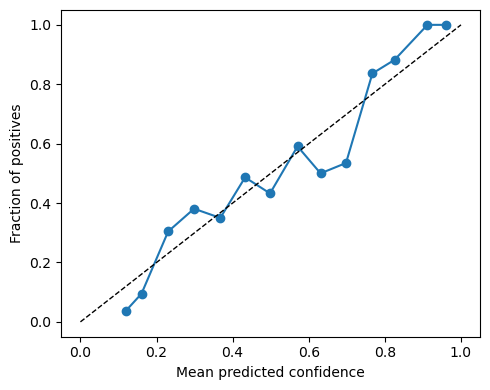

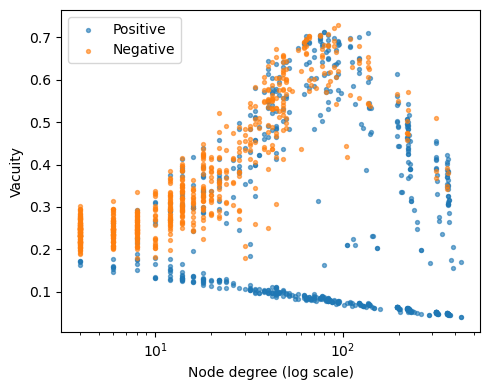

In [38]:
# Numerical Summary (Evidence, Vacuity, Entropy)

def summarize_stats(name, S, p, vac, ent):
    S, p, vac, ent = map(lambda x: x.cpu().numpy(), [S, p, vac, ent])
    print(f"\n{name} EPN Statistics:")
    print("  Evidence mean:",    np.mean(S).round(4))
    print("  Evidence median:",  np.median(S).round(4))
    print("  Vacuity mean:",     np.mean(vac).round(4))
    print("  Vacuity median:",   np.median(vac).round(4))
    print("  Entropy mean:",     np.mean(ent).round(4))
    print("  Entropy median:",   np.median(ent).round(4))
    print("  p05 evidence:",     np.percentile(S, 5).round(4))
    print("  p95 evidence:",     np.percentile(S, 95).round(4))

summarize_stats("Positive", S_pos, p_pos, vac_pos, ent_pos)
summarize_stats("Negative", S_neg, p_neg, vac_neg, ent_neg)


# Calibration Plot (Expected vs Confidence)

# combine pos + neg
p_all  = torch.cat([p_pos,  p_neg]).cpu().numpy()
y_all  = np.concatenate([np.ones(len(p_pos)), np.zeros(len(p_neg))])

frac_pos, mean_conf = calibration_curve(y_all, p_all, n_bins=15, strategy="uniform")

plt.figure(figsize=(5,4))
plt.plot(mean_conf, frac_pos, "o-", label="EPN")
plt.plot([0,1],[0,1], "k--", linewidth=1)

plt.xlabel("Mean predicted confidence")
plt.ylabel("Fraction of positives")
plt.tight_layout()
plt.savefig("stageB_calibration.png", dpi=300, bbox_inches="tight")
plt.show()


# Vacuity vs Node Degree

# degrees for circ/disease nodes
deg = torch.zeros(Z.shape[0], dtype=torch.float)
for u,v,_ in G["CD"]:
    deg[u] += 1
    deg[v] += 1

deg = deg.cpu().numpy()

pos_idx_u = pos_pairs[:,0].cpu().numpy()
pos_idx_v = pos_pairs[:,1].cpu().numpy()
neg_idx_u = neg_pairs[:,0].cpu().numpy()
neg_idx_v = neg_pairs[:,1].cpu().numpy()

deg_pos = deg[pos_idx_u] + deg[pos_idx_v]
deg_neg = deg[neg_idx_u] + deg[neg_idx_v]

plt.figure(figsize=(5,4))
plt.scatter(deg_pos, vac_pos.cpu().numpy(), s=8, alpha=0.6, label="Positive")
plt.scatter(deg_neg, vac_neg.cpu().numpy(), s=8, alpha=0.6, label="Negative")

plt.xscale("log")
plt.xlabel("Node degree (log scale)")
plt.ylabel("Vacuity")
plt.legend()
plt.tight_layout()
plt.savefig("stageB_vacuity_degree.png", dpi=300, bbox_inches="tight")
plt.show()

In [39]:
# Case Study Candidate Extraction

# compute node degrees for context
deg = torch.zeros(Z.shape[0], dtype=torch.float)
for u, v, _ in G["CD"]:
    deg[u] += 1
    deg[v] += 1
deg = deg.cpu().numpy()

# restrict to positive validation pairs
u_pos = pos_pairs[:, 0]
v_pos = pos_pairs[:, 1]

deg_pair = deg[u_pos.numpy()] + deg[v_pos.numpy()]

# build dataframe
df = pd.DataFrame({
    "u": u_pos.numpy(),
    "v": v_pos.numpy(),
    "p": p_pos.cpu().numpy(),
    "evidence": S_pos.cpu().numpy(),
    "vacuity": vac_pos.cpu().numpy(),
    "entropy": ent_pos.cpu().numpy(),
    "degree_sum": deg_pair
})

# Category A: high prob, low vacuity
A = df[
    (df["p"] > 0.8) &
    (df["vacuity"] < 0.15)
].sort_values("p", ascending=False).head(10)

# Category B: high prob, high vacuity
B = df[
    (df["p"] > 0.8) &
    (df["vacuity"] > 0.25)
].sort_values("vacuity", ascending=False).head(10)

# Category C: moderate prob, high vacuity
C = df[
    (df["p"].between(0.5, 0.75)) &
    (df["vacuity"] > 0.28)
].sort_values("vacuity", ascending=False).head(10)

print("\nCategory A: High-confidence, low-uncertainty")
display(A)

print("\nCategory B: High-confidence, high-uncertainty")
display(B)

print("\nCategory C: Moderate-confidence, high-uncertainty")
display(C)



Category A: High-confidence, low-uncertainty


,u,v,p,evidence,vacuity,entropy,degree_sum
646,1464,51,0.980411,51.047894,0.039179,0.096437,428.0
23,1464,51,0.980411,51.047894,0.039179,0.096437,428.0
592,1464,1140,0.977731,44.905243,0.044538,0.106743,374.0
140,1464,481,0.977682,44.807026,0.044636,0.106928,374.0
364,1589,51,0.977136,43.736759,0.045728,0.108985,290.0
119,1589,51,0.977136,43.736759,0.045728,0.108985,290.0
560,1464,27,0.977128,43.722141,0.045743,0.109014,370.0
204,1464,891,0.976919,43.325558,0.046162,0.109799,366.0
357,1464,372,0.976733,42.978539,0.046535,0.110496,366.0
371,1565,106,0.976726,42.966770,0.046548,0.110520,324.0



Category B: High-confidence, high-uncertainty


,u,v,p,evidence,vacuity,entropy,degree_sum
491,839,1565,0.803658,5.093362,0.392668,0.495289,314.0
25,529,1589,0.804630,5.120946,0.390553,0.493916,228.0
347,529,1589,0.804630,5.120946,0.390553,0.493916,228.0
256,1427,1589,0.804804,5.127316,0.390068,0.493671,230.0
214,1244,1565,0.805210,5.133918,0.389566,0.493095,314.0
574,915,1528,0.802127,5.154943,0.387977,0.497439,134.0
193,490,1464,0.806184,5.159671,0.387622,0.491709,362.0
270,513,1464,0.807938,5.206846,0.384110,0.489199,364.0
228,1294,1464,0.808842,5.231466,0.382302,0.487898,364.0
361,226,1464,0.811423,5.302977,0.377147,0.484153,362.0



Category C: Moderate-confidence, high-uncertainty


,u,v,p,evidence,vacuity,entropy,degree_sum
613,1070,1446,0.564956,2.805336,0.712927,0.684685,80.0
98,1127,1446,0.573745,2.807946,0.712264,0.682231,80.0
546,400,1470,0.625918,2.817732,0.709791,0.661093,136.0
394,223,1538,0.538396,2.830576,0.706570,0.690196,84.0
255,409,1459,0.560142,2.838010,0.704719,0.685896,76.0
453,849,1585,0.532189,2.848500,0.702124,0.691073,64.0
478,339,1459,0.566783,2.848520,0.702119,0.684200,76.0
299,129,1528,0.633443,2.851482,0.701390,0.657098,122.0
615,970,1541,0.619040,2.859279,0.699477,0.664532,90.0
226,216,1459,0.589617,2.861111,0.699029,0.676998,76.0


In [40]:
# load graph
with open("datasets/final_graph.pkl", "rb") as f:
    G = pickle.load(f)

circ_ids = G["circ_ids"]      # circRNA_name -> index
dis_ids  = G["dis_ids"]       # disease_name (DOID) -> index
gene_ids = G["gene_ids"]      # gene_symbol -> index

# invert dictionaries
circ_id2name = {v: k for k, v in circ_ids.items()}
dis_id2name  = {v: k for k, v in dis_ids.items()}
gene_id2name = {v: k for k, v in gene_ids.items()}

print("Loaded node dictionaries.")
print("Total circRNAs:", len(circ_id2name))
print("Total diseases:", len(dis_id2name))
print("Total genes:", len(gene_id2name))


def lookup_node(idx):
    if idx in circ_id2name:
        return "circRNA", circ_id2name[idx]
    elif idx in dis_id2name:
        return "disease", dis_id2name[idx]
    elif idx in gene_id2name:
        return "gene", gene_id2name[idx]
    else:
        return "unknown", str(idx)

Loaded node dictionaries.
Total circRNAs: 1440
Total diseases: 160
Total genes: 1145


In [41]:
# Known CD edges as a fast lookup set
known_cd = set((int(u), int(v)) for u, v, _ in G["CD"])
print("Known CD:", len(known_cd))

@torch.no_grad()
def score_all(model, Z, n_circ, n_dis):
    circ = torch.arange(n_circ)
    dis  = torch.arange(n_dis) + n_circ

    U = circ.repeat_interleave(n_dis)
    V = dis.repeat(n_circ)

    scores = torch.sigmoid(model.scorer(Z[U], Z[V]))
    return U.cpu(), V.cpu(), scores.cpu()

U_all, V_all, S_all = score_all(model, Z, G["n_circ"], G["n_dis"])

# sort all pairs by predicted score
idx_sorted = torch.argsort(S_all, descending=True)

novel = []

for idx in idx_sorted:
    u = int(U_all[idx])
    v = int(V_all[idx])
    if (u, v) not in known_cd:
        novel.append((u, v, float(S_all[idx])))
    if len(novel) == 200:  # collect top 50 new edges
        break

print("Novel predictions collected:", len(novel))

circ_rev = {idx: name for name, idx in G["circ_ids"].items()}
dis_rev  = {idx: name for name, idx in G["dis_ids"].items()}

u_best, v_best, s_best = novel[0]

circ_best = circ_rev[u_best]
dis_best  = dis_rev[v_best]

print("Top NEW predicted link:")
print("circRNA:", circ_best)
print("disease:", dis_best)
print("predicted score:", s_best)


Known CD: 3784
Novel predictions collected: 200
Top NEW predicted link:
circRNA: hsa_circ_0000615
disease: DOID:684
predicted score: 0.903049647808075


In [42]:
def summarize(name, S, p, vac, ent):
    print(name)
    print("  mean evidence:", float(S.mean()))
    print("  mean prob:", float(p.mean()))
    print("  mean vacuity:", float(vac.mean()))
    print("  mean entropy:", float(ent.mean()))
    print()

summarize("Positive CD edges", S_pos, p_pos, vac_pos, ent_pos)
summarize("Negative sampled edges", S_neg, p_neg, vac_neg, ent_neg)

def random_pairs(n, n_circ, n_dis):
    u = torch.randint(0, n_circ, (n,))
    v = torch.randint(n_circ, n_circ+n_dis, (n,))
    return torch.stack([u, v], dim=1)

rand_pairs = random_pairs(2000, G["n_circ"], G["n_dis"])
S_r, p_r, vac_r, ent_r = score_epn(epn, Z, rand_pairs)

summarize("Random circRNA–disease pairs", S_r, p_r, vac_r, ent_r)

circ_range = G["n_circ"]

degree = torch.zeros(G["n_circ"])

for u,v,_ in G["CD"]:
    if u < circ_range:      # circRNA node
        degree[u] += 1


rare = torch.where(degree <= 1)[0]
idx = torch.randint(0, rare.shape[0], (2000,))
u = rare[idx]
v = torch.randint(G["n_circ"], G["n_circ"]+G["n_dis"], (2000,))
rare_pairs = torch.stack([u, v], dim=1)

S_c, p_c, vac_c, ent_c = score_epn(epn, Z, rare_pairs)

summarize("Pairs involving rare circRNAs", S_c, p_c, vac_c, ent_c)

# Identify diseases used in training
train_dis_set = set(int(v) for _, v in CD_train.cpu())

# All diseases in graph
all_dis = list(range(G["n_circ"], G["n_circ"] + G["n_dis"]))

ood_dis = [d for d in all_dis if d not in train_dis_set]
ood_dis = torch.tensor(ood_dis)

# Sample OOD disease-circ pairs
idx = torch.randint(0, ood_dis.shape[0], (2000,))
u = torch.randint(0, G["n_circ"], (2000,))
v = ood_dis[idx]

ood_pairs = torch.stack([u, v], dim=1)

S_ood, p_ood, vac_ood, ent_ood = score_epn(epn, Z, ood_pairs)

summarize("OOD disease pairs", S_ood, p_ood, vac_ood, ent_ood)

high = torch.where(degree >= degree.quantile(0.9))[0]  # top 10% degree
idx = torch.randint(0, high.shape[0], (2000,))
u = high[idx]
v = torch.randint(G["n_circ"], G["n_circ"]+G["n_dis"], (2000,))

high_pairs = torch.stack([u, v], dim=1)

S_h, p_h, vac_h, ent_h = score_epn(epn, Z, high_pairs)
summarize("High-degree circRNAs", S_h, p_h, vac_h, ent_h)

device = E_r.device

E_u = E_u.to(device)
E_w = E_w.to(device)

# Extract CC edges only
mask_cc = (E_r == 0)
u_cc = E_u[mask_cc]
w_cc = E_w[mask_cc]

# average similarity for each circRNA
sim = torch.zeros(G["n_circ"], device=device)
count = torch.zeros(G["n_circ"], device=device)

for u, w in zip(u_cc, w_cc):
    if u < G["n_circ"]:
        sim[u] += w
        count[u] += 1

sim = sim / (count + 1e-12)

# threshold: lowest 10%
thr = torch.quantile(sim, 0.1)
low_sim_nodes = torch.where(sim <= thr)[0]

idx = torch.randint(0, low_sim_nodes.shape[0], (2000,), device=device)
u = low_sim_nodes[idx]
v = torch.randint(G["n_circ"], G["n_circ"] + G["n_dis"], (2000,), device=device)

low_sim_pairs = torch.stack([u, v], dim=1)

Z = Z.to(device)
low_sim_pairs = low_sim_pairs.to(device)
epn = epn.to(device)

S_ls, p_ls, vac_ls, ent_ls = score_epn(epn, Z, low_sim_pairs)
summarize("Low-similarity circRNAs", S_ls, p_ls, vac_ls, ent_ls)

cg_degree = torch.zeros(G["n_circ"])
for u,v,_ in G["CG"]:
    if u < G["n_circ"]:
        cg_degree[u] += 1

high_cg = torch.where(cg_degree >= cg_degree.quantile(0.9))[0]

idx = torch.randint(0, high_cg.shape[0], (2000,))
u = high_cg[idx]
v = torch.randint(G["n_circ"], G["n_circ"]+G["n_dis"], (2000,))
cg_pairs = torch.stack([u, v], dim=1)

S_cg, p_cg, vac_cg, ent_cg = score_epn(epn, Z, cg_pairs)

summarize("High-gene-degree circRNAs", S_cg, p_cg, vac_cg, ent_cg)

u = torch.randint(0, G["n_circ"], (3000,))
v = torch.randint(G["n_circ"], G["n_circ"]+G["n_dis"], (3000,))
rand_all_pairs = torch.stack([u, v], dim=1)

S_ra, p_ra, vac_ra, ent_ra = score_epn(epn, Z, rand_all_pairs)

summarize("Full random circRNA–disease pairs", S_ra, p_ra, vac_ra, ent_ra)

print("Top 20 NEW predicted links:\n")

for i, (u, v, s) in enumerate(novel[:20]):
    circ = circ_rev[u]
    dis  = dis_rev[v]
    print(f"{i+1:2d}.  circRNA: {circ:20s}   disease: {dis:12s}   score: {s:.4f}")


Positive CD edges
  mean evidence: 15.675480842590332
  mean prob: 0.750766396522522
  mean vacuity: 0.27090591192245483
  mean entropy: 0.36972716450691223

Negative sampled edges
  mean evidence: 6.363458633422852
  mean prob: 0.2591816484928131
  mean vacuity: 0.3583481013774872
  mean entropy: 0.49661320447921753

Random circRNA–disease pairs
  mean evidence: 6.372307777404785
  mean prob: 0.25609418749809265
  mean vacuity: 0.3572644889354706
  mean entropy: 0.497583270072937

Pairs involving rare circRNAs
  mean evidence: 6.298424243927002
  mean prob: 0.251616895198822
  mean vacuity: 0.36184871196746826
  mean entropy: 0.49097853899002075

OOD disease pairs
  mean evidence: 8.501341819763184
  mean prob: 0.1325010508298874
  mean vacuity: 0.2382764220237732
  mean entropy: 0.3892395794391632

High-degree circRNAs
  mean evidence: 6.751017093658447
  mean prob: 0.2676265835762024
  mean vacuity: 0.3304213285446167
  mean entropy: 0.5017709136009216

Low-similarity circRNAs
  mea

In [46]:
@torch.no_grad()
def collect_stats(model, epn, Z, pairs):
    zu, zv = Z[pairs[:,0]], Z[pairs[:,1]]
    logits = model.scorer(zu, zv)
    scores = torch.sigmoid(logits)

    alpha = epn(zu, zv)
    S, p, vac, ent = dirichlet_stats(alpha)

    return {
        "scores": scores.cpu(),
        "evidence": S.cpu(),
        "prob": p.cpu(),
        "vacuity": vac.cpu(),
        "entropy": ent.cpu()
    }

def summarize_block(name, stats):
    s, S, vac = stats["scores"], stats["evidence"], stats["vacuity"]
    print(name)
    print("  scores:   mean {:.4f} | 25% {:.4f} | 75% {:.4f} | max {:.4f}".format(
        float(s.mean()), float(s.quantile(0.25)), float(s.quantile(0.75)), float(s.max())
    ))
    print("  evidence: mean {:.3f}".format(float(S.mean())))
    print("  vacuity:  mean {:.3f}".format(float(vac.mean())))
    print()

def make_pairs_mask(n_samples, kind):
    if kind == "pos":
        idx = torch.randint(0, CD_val.shape[0], (n_samples,))
        return CD_val[idx].cpu()

    if kind == "neg":
        u,v = sample_neg(n_samples, G["n_circ"], G["n_dis"], device="cuda")
        u = u.cpu()
        v = v.cpu()

        return torch.stack([u.cpu(), v.cpu()],1)

    if kind == "rand":
        u = torch.randint(0, G["n_circ"], (n_samples,), device="cpu")
        v = torch.randint(G["n_circ"], G["n_circ"] + G["n_dis"], (n_samples,), device="cpu")
        return torch.stack([u, v],1)

    if kind == "rare":
        r = rare.cpu()
        idx = torch.randint(0, r.shape[0], (n_samples,), device="cpu")
        u = r[idx]
        v = torch.randint(G["n_circ"], G["n_circ"] + G["n_dis"], (n_samples,), device="cpu")
        return torch.stack([u, v],1)

    if kind == "ood":
        o = ood_dis.cpu()
        idx = torch.randint(0, o.shape[0], (n_samples,), device="cpu")
        u = torch.randint(0, G["n_circ"], (n_samples,), device="cpu")
        v = o[idx]
        return torch.stack([u, v],1)

    if kind == "highdeg":
        h = high.cpu()
        idx = torch.randint(0, h.shape[0], (n_samples,), device="cpu")
        u = h[idx]
        v = torch.randint(G["n_circ"], G["n_circ"] + G["n_dis"], (n_samples,), device="cpu")
        return torch.stack([u, v],1)

    if kind == "lowsim":
        ls = low_sim_nodes.cpu()
        idx = torch.randint(0, ls.shape[0], (n_samples,), device="cpu")
        u = ls[idx]
        v = torch.randint(G["n_circ"], G["n_circ"] + G["n_dis"], (n_samples,), device="cpu")
        return torch.stack([u, v],1)



categories = {
    "Positive edges (val)": "pos",
    "Sampled negatives": "neg",
    "Random circ–dis pairs": "rand",
    "Rare circRNAs": "rare",
    "OOD diseases": "ood",
    "High-degree circRNAs": "highdeg",
    "Low-sim circRNAs": "lowsim"
}

results = {}
for name, kind in categories.items():
    pairs = make_pairs_mask(2000, kind)
    results[name] = collect_stats(model, epn, Z, pairs)

print("\nDISTRIBUTIONS\n")
for name in categories:
    summarize_block(name, results[name])

print("\nREPRESENTATIVE EXAMPLES\n")

def show_examples(name, stats, pairs, k=5):
    s = stats["scores"]
    S = stats["evidence"]
    vac = stats["vacuity"]

    print(name)

    idx_high = torch.topk(s, k).indices
    print("  High-score examples:")
    for i in idx_high:
        u,v = pairs[i]
        print(f"    (circ {int(u)}, dis {int(v)}) score {float(s[i]):.4f}  evid {float(S[i]):.2f}  vac {float(vac[i]):.2f}")

    idx_low = torch.topk(-s, k).indices
    print("  Low-score examples:")
    for i in idx_low:
        u,v = pairs[i]
        print(f"    (circ {int(u)}, dis {int(v)}) score {float(s[i]):.4f}  evid {float(S[i]):.2f}  vac {float(vac[i]):.2f}")
    print()


for name, kind in categories.items():
    pairs = make_pairs_mask(2000, kind)
    show_examples(name, results[name], pairs)



DISTRIBUTIONS

Positive edges (val)
  scores:   mean 0.6715 | 25% 0.5956 | 75% 0.7501 | max 0.9604
  evidence: mean 15.640
  vacuity:  mean 0.274

Sampled negatives
  scores:   mean 0.5656 | 25% 0.5284 | 75% 0.5919 | max 0.8418
  evidence: mean 6.333
  vacuity:  mean 0.361

Random circ–dis pairs
  scores:   mean 0.5649 | 25% 0.5284 | 75% 0.5911 | max 0.9564
  evidence: mean 6.379
  vacuity:  mean 0.357

Rare circRNAs
  scores:   mean 0.5609 | 25% 0.5274 | 75% 0.5849 | max 0.7867
  evidence: mean 6.255
  vacuity:  mean 0.364

OOD diseases
  scores:   mean 0.5143 | 25% 0.4899 | 75% 0.5296 | max 0.5701
  evidence: mean 8.487
  vacuity:  mean 0.239

High-degree circRNAs
  scores:   mean 0.5722 | 25% 0.5328 | 75% 0.6006 | max 0.8658
  evidence: mean 6.749
  vacuity:  mean 0.332

Low-sim circRNAs
  scores:   mean 0.5626 | 25% 0.5270 | 75% 0.5870 | max 0.8675
  evidence: mean 6.167
  vacuity:  mean 0.367


REPRESENTATIVE EXAMPLES

Positive edges (val)
  High-score examples:
    (circ 1537, d

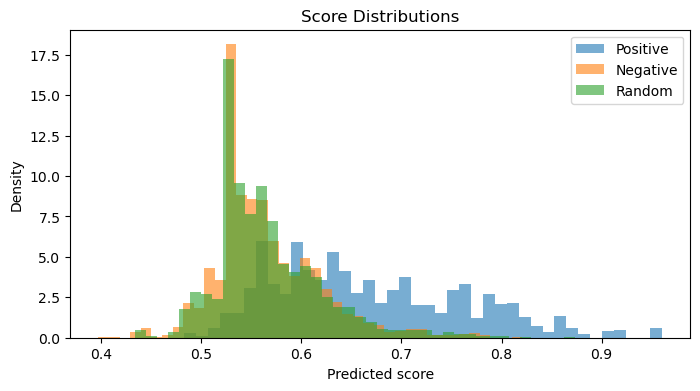

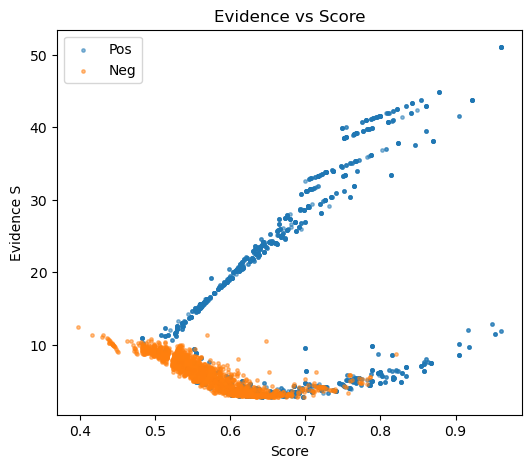

In [47]:
# collect scores again for 2000 samples per class
pairs_pos  = make_pairs_mask(2000, "pos")
pairs_neg  = make_pairs_mask(2000, "neg")
pairs_rand = make_pairs_mask(2000, "rand")

stats_pos  = collect_stats(model, epn, Z, pairs_pos)
stats_neg  = collect_stats(model, epn, Z, pairs_neg)
stats_rand = collect_stats(model, epn, Z, pairs_rand)

plt.figure(figsize=(8,4))
plt.hist(stats_pos["scores"], bins=40, alpha=0.6, label="Positive", density=True)
plt.hist(stats_neg["scores"], bins=40, alpha=0.6, label="Negative", density=True)
plt.hist(stats_rand["scores"], bins=40, alpha=0.6, label="Random", density=True)
plt.xlabel("Predicted score")
plt.ylabel("Density")
plt.legend()
plt.title("Score Distributions")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(stats_pos["scores"], stats_pos["evidence"], s=6, alpha=0.5, label="Pos")
plt.scatter(stats_neg["scores"], stats_neg["evidence"], s=6, alpha=0.5, label="Neg")
plt.xlabel("Score")
plt.ylabel("Evidence S")
plt.title("Evidence vs Score")
plt.legend()
plt.show()


In [49]:
def collect(pairs):
    s, p, vac, ent = score_epn(epn, Z, pairs)
    return {
        "score": s.cpu(),
        "prob": p.cpu(),
        "evidence": (1.0 / vac).cpu(),   # since vac = 2/S, evidence = S
        "vacuity": vac.cpu(),
        "entropy": ent.cpu()
    }

def summarize_stats(name, stats):
    s = stats["score"]
    ev = stats["evidence"]
    vac = stats["vacuity"]
    ent = stats["entropy"]

    print(f"\n{name}")
    print(f"scores:    mean {float(s.mean()):.4f} | med {float(s.median()):.4f} | std {float(s.std()):.4f}")
    print(f"scores:    min {float(s.min()):.4f} | 25% {np.percentile(s,25):.4f} | 75% {np.percentile(s,75):.4f} | max {float(s.max()):.4f}")
    print(f"evidence:  mean {float(ev.mean()):.4f} | med {float(ev.median()):.4f}")
    print(f"vacuity:   mean {float(vac.mean()):.4f} | med {float(vac.median()):.4f}")
    print(f"entropy:   mean {float(ent.mean()):.4f} | med {float(ent.median()):.4f}")


def pearson(a,b):
    a,b = a.numpy(), b.numpy()
    return float(np.corrcoef(a,b)[0,1])


def compare_dists(a, b):
    from scipy.stats import ks_2samp, wasserstein_distance
    ks = ks_2samp(a.numpy(), b.numpy())
    wd = wasserstein_distance(a.numpy(), b.numpy())
    return ks.statistic, ks.pvalue, wd


# categories
pairs_pos  = make_pairs_mask(2000, "pos")
pairs_neg  = make_pairs_mask(2000, "neg")
pairs_rand = make_pairs_mask(2000, "rand")
pairs_ood  = make_pairs_mask(2000, "ood")
pairs_rare = make_pairs_mask(2000, "rare")
pairs_hdeg = make_pairs_mask(2000, "highdeg")
pairs_lsim = make_pairs_mask(2000, "lowsim")

cats = {
    "Positive (val)": pairs_pos,
    "Negatives":       pairs_neg,
    "Random":          pairs_rand,
    "OOD":             pairs_ood,
    "Rare circRNAs":   pairs_rare,
    "High-degree":     pairs_hdeg,
    "Low-sim":         pairs_lsim
}

# collect all results
raw = {name: collect(p) for name,p in cats.items()}

# numerical summaries
for name in raw:
    summarize_stats(name, raw[name])


# separation tests (Pos vs others)
print("\n\nDISTRIBUTION SEPARATION TESTS (Positive vs Others)")
for name in ["Negatives", "Random", "OOD", "Rare circRNAs", "High-degree", "Low-sim"]:
    ks, pval, wd = compare_dists(raw["Positive (val)"]["score"], raw[name]["score"])
    print(f"{name:15s} | KS={ks:.4f}, p={pval:.3e}, WD={wd:.4f}")


# uncertainty-score correlations
print("\n\nPEARSON CORRELATIONS")
for name in raw:
    s   = raw[name]["score"]
    ev  = raw[name]["evidence"]
    vac = raw[name]["vacuity"]
    ent = raw[name]["entropy"]
    print(f"{name}")
    print(f"  corr(score, evidence): {pearson(s, ev):.4f}")
    print(f"  corr(score, vacuity):  {pearson(s, vac):.4f}")
    print(f"  corr(score, entropy):  {pearson(s, ent):.4f}")


# anomaly detection
def find_examples(stats, k=5):
    s = stats["score"]
    ev = stats["evidence"]
    vac = stats["vacuity"]

    idx_high_s_low_ev = torch.argsort(s - ev, descending=True)[:k]
    idx_low_s_high_ev = torch.argsort(ev - s, descending=True)[:k]

    return {
        "high_score_low_evidence": idx_high_s_low_ev,
        "low_score_high_evidence": idx_low_s_high_ev
    }

print("\n\nANOMALY EXAMPLES (Positive set)")
anom = find_examples(raw["Positive (val)"], k=10)
print("Indices of high-score but low-evidence:", anom["high_score_low_evidence"].tolist())
print("Indices of low-score but high-evidence:", anom["low_score_high_evidence"].tolist())


Positive (val)
scores:    mean 16.2108 | med 12.8893 | std 12.7829
scores:    min 2.8053 | 25% 4.5432 | 75% 25.1412 | max 51.0479
evidence:  mean 8.1054 | med 6.4446
vacuity:   mean 0.2624 | med 0.1552
entropy:   mean 0.3597 | med 0.2728

Negatives
scores:    mean 6.4158 | med 6.5797 | std 2.0408
scores:    min 2.6434 | 25% 4.8193 | 75% 8.1308 | max 12.2342
evidence:  mean 3.2079 | med 3.2899
vacuity:   mean 0.3537 | med 0.3039
entropy:   mean 0.4938 | med 0.4699

Random
scores:    mean 6.5020 | med 6.8091 | std 2.0310
scores:    min 2.7068 | 25% 4.8725 | 75% 8.1646 | max 11.3657
evidence:  mean 3.2510 | med 3.4046
vacuity:   mean 0.3482 | med 0.2935
entropy:   mean 0.4900 | med 0.4630

OOD
scores:    mean 8.4169 | med 8.3239 | std 0.9610
scores:    min 6.2387 | 25% 7.7030 | 75% 9.0457 | max 12.7357
evidence:  mean 4.2084 | med 4.1619
vacuity:   mean 0.2406 | med 0.2402
entropy:   mean 0.3923 | med 0.3888

Rare circRNAs
scores:    mean 6.2387 | med 6.4480 | std 2.0707
scores:    min 2

In [52]:
# degree
deg = torch.zeros(Z.shape[0], dtype=torch.float)
for u, v, _ in G["CD"]:
    deg[u] += 1
    deg[v] += 1
deg = deg.cpu().numpy()

# positive pairs
u_p = pos_pairs[:, 0].numpy()
v_p = pos_pairs[:, 1].numpy()
deg_p = deg[u_p] + deg[v_p]

df = pd.DataFrame({
    "u": u_p,
    "v": v_p,
    "p": p_pos.cpu().numpy(),
    "S": S_pos.cpu().numpy(),
    "vac": vac_pos.cpu().numpy(),
    "ent": ent_pos.cpu().numpy(),
    "deg_sum": deg_p
})

# load dictionaries
circ_id2name = {v: k for k, v in G["circ_ids"].items()}
dis_id2name  = {v: k for k, v in G["dis_ids"].items()}
gene_id2name = {v: k for k, v in G["gene_ids"].items()}

# map id to biological label
def id_to_label(i):
    if i in circ_id2name:
        return "circRNA", circ_id2name[i]
    if i in dis_id2name:
        return "disease", dis_id2name[i]
    if i in gene_id2name:
        return "gene", gene_id2name[i]
    return "unknown", str(i)

# attach labels
def attach(df):
    t_u = []
    n_u = []
    t_v = []
    n_v = []
    for i, j in zip(df["u"].values, df["v"].values):
        tu, nu = id_to_label(i)
        tv, nv = id_to_label(j)
        t_u.append(tu)
        n_u.append(nu)
        t_v.append(tv)
        n_v.append(nv)
    df = df.copy()
    df["u_type"] = t_u
    df["u_name"] = n_u
    df["v_type"] = t_v
    df["v_name"] = n_v
    return df

# category filters
A = df[(df["p"] > 0.8) & (df["vac"] < 0.15)].sort_values("p", ascending=False).head(10)
B = df[(df["p"] > 0.8) & (df["vac"] > 0.25)].sort_values("vac", ascending=False).head(10)
C = df[(df["p"].between(0.5, 0.75)) & (df["vac"] > 0.28)].sort_values("vac", ascending=False).head(10)

A = attach(A)
B = attach(B)
C = attach(C)

print("\nCategory A")
display(A[["u","u_type","u_name","v","v_type","v_name","p","vac","ent","deg_sum"]])

print("\nCategory B")
display(B[["u","u_type","u_name","v","v_type","v_name","p","vac","ent","deg_sum"]])

print("\nCategory C")
display(C[["u","u_type","u_name","v","v_type","v_name","p","vac","ent","deg_sum"]])


Category A


,u,u_type,u_name,v,v_type,v_name,p,vac,ent,deg_sum
646,1464,disease,DOID:10534,51,circRNA,hsa_circ_0000284,0.980411,0.039179,0.096437,428.0
23,1464,disease,DOID:10534,51,circRNA,hsa_circ_0000284,0.980411,0.039179,0.096437,428.0
592,1464,disease,DOID:10534,1140,circRNA,hsa_circ_0072309,0.977731,0.044538,0.106743,374.0
140,1464,disease,DOID:10534,481,circRNA,hsa_circ_0006156,0.977682,0.044636,0.106928,374.0
364,1589,disease,DOID:9256,51,circRNA,hsa_circ_0000284,0.977136,0.045728,0.108985,290.0
119,1589,disease,DOID:9256,51,circRNA,hsa_circ_0000284,0.977136,0.045728,0.108985,290.0
560,1464,disease,DOID:10534,27,circRNA,hsa_circ_0000144,0.977128,0.045743,0.109014,370.0
204,1464,disease,DOID:10534,891,circRNA,hsa_circ_0040039,0.976919,0.046162,0.109799,366.0
357,1464,disease,DOID:10534,372,circRNA,hsa_circ_0004104,0.976733,0.046535,0.110496,366.0
371,1565,disease,DOID:684,106,circRNA,hsa_circ_0000677,0.976726,0.046548,0.110520,324.0



Category B


,u,u_type,u_name,v,v_type,v_name,p,vac,ent,deg_sum
491,839,circRNA,hsa_circ_0032704,1565,disease,DOID:684,0.803658,0.392668,0.495289,314.0
25,529,circRNA,hsa_circ_0007142,1589,disease,DOID:9256,0.804630,0.390553,0.493916,228.0
347,529,circRNA,hsa_circ_0007142,1589,disease,DOID:9256,0.804630,0.390553,0.493916,228.0
256,1427,circRNA,hsa_circ_0136666,1589,disease,DOID:9256,0.804804,0.390068,0.493671,230.0
214,1244,circRNA,hsa_circ_0084922,1565,disease,DOID:684,0.805210,0.389566,0.493095,314.0
574,915,circRNA,hsa_circ_0043278,1528,disease,DOID:3347,0.802127,0.387977,0.497439,134.0
193,490,circRNA,hsa_circ_0006282,1464,disease,DOID:10534,0.806184,0.387622,0.491709,362.0
270,513,circRNA,hsa_circ_0006835,1464,disease,DOID:10534,0.807938,0.384110,0.489199,364.0
228,1294,circRNA,hsa_circ_0089548,1464,disease,DOID:10534,0.808842,0.382302,0.487898,364.0
361,226,circRNA,hsa_circ_0001725,1464,disease,DOID:10534,0.811423,0.377147,0.484153,362.0



Category C


,u,u_type,u_name,v,v_type,v_name,p,vac,ent,deg_sum
613,1070,circRNA,hsa_circ_0063772,1446,disease,DOID:0050866,0.564956,0.712927,0.684685,80.0
98,1127,circRNA,hsa_circ_0070401,1446,disease,DOID:0050866,0.573745,0.712264,0.682231,80.0
546,400,circRNA,hsa_circ_0004826,1470,disease,DOID:11054,0.625918,0.709791,0.661093,136.0
394,223,circRNA,hsa_circ_0001715,1538,disease,DOID:3910,0.538396,0.706570,0.690196,84.0
255,409,circRNA,hsa_circ_0004916,1459,disease,DOID:10283,0.560142,0.704719,0.685896,76.0
453,849,circRNA,hsa_circ_0034398,1585,disease,DOID:9074,0.532189,0.702124,0.691073,64.0
478,339,circRNA,hsa_circ_0003456,1459,disease,DOID:10283,0.566783,0.702119,0.684200,76.0
299,129,circRNA,hsa_circ_0000885,1528,disease,DOID:3347,0.633443,0.701390,0.657098,122.0
615,970,circRNA,hsa_circ_0050707,1541,disease,DOID:3969,0.619040,0.699477,0.664532,90.0
226,216,circRNA,hsa_circ_0001633,1459,disease,DOID:10283,0.589617,0.699029,0.676998,76.0


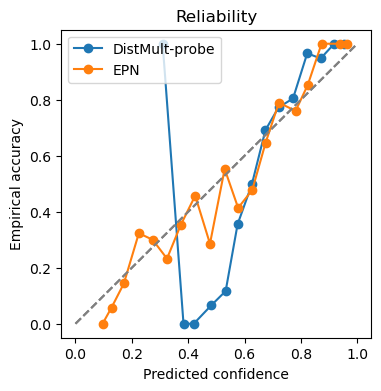

In [53]:
def plot_reliability(p, y, n_bins=20, label="model"):
    conf, acc, count = reliability_data(p, y, n_bins=n_bins)

    conf_ = [c for c in conf if c is not None]
    acc_  = [a for a in acc  if a is not None]

    plt.plot(conf_, acc_, marker='o', label=label)
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel("Predicted confidence")
    plt.ylabel("Empirical accuracy")
    plt.title("Reliability")
    plt.legend()

plt.figure(figsize=(4,4))
plot_reliability(p_probe, y_probe, label="DistMult-probe")
plot_reliability(p_epn,   y_epn,   label="EPN")
plt.savefig("paper_reliability.png", dpi=300, bbox_inches='tight')
plt.show()

In [51]:
plt.figure(figsize=(6,5))

# Relationship: vacuity vs degree sum (structural support)
sns.regplot(
    x=df["deg_sum"],
    y=df["vac"],
    scatter_kws={"s": 20, "alpha": 0.4},
    line_kws={"color": "red"},
)

plt.xlabel("Structural support (degree of circRNA + degree of disease)")
plt.ylabel("Vacuity (epistemic uncertainty)")
plt.title("Uncertainty vs. Structural Support (CD positive pairs)")
plt.grid(True)
plt.savefig("paper_uncertainty.png", dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'deg_sum'

<Figure size 600x500 with 0 Axes>

In [ ]:
# global node IDs for diseases of interest
d_bc   = G["dis_ids"]["DOID:1612"]
d_hcc  = G["dis_ids"]["DOID:684"]

d_bc, d_hcc


In [ ]:
@torch.no_grad()
def evaluate_disease(epn, Z, circ_ids, dis_id):
    u = circ_ids
    v = torch.full_like(circ_ids, dis_id)

    zu = Z[u]
    zv = Z[v]

    alpha = epn(zu, zv)
    S = alpha.sum(dim=-1)                   # total evidence
    p = (alpha / S.unsqueeze(1))[:, 0]      # class-0 prob
    vac = 2.0 / (S + 1e-12)                 # vacuity
    ent = -(p*torch.log(p+1e-12) + (1-p)*torch.log(1-p+1e-12))

    return {
        "u": u.cpu(),
        "p": p.cpu(),
        "vac": vac.cpu(),
        "ent": ent.cpu()
    }


In [ ]:
circ_ids_tensor = torch.tensor(
    list(G["circ_ids"].values()), dtype=torch.long, device=Z.device
)

res_bc  = evaluate_disease(epn, Z, circ_ids_tensor, d_bc)
res_hcc = evaluate_disease(epn, Z, circ_ids_tensor, d_hcc)


In [ ]:
def build_df(res, dis_name):
    circ_names = [circ_id2name[int(i)] for i in res["u"]]
    return pd.DataFrame({
        "circ": circ_names,
        "u": res["u"].numpy(),
        "disease": dis_name,
        "p": res["p"].numpy(),
        "vac": res["vac"].numpy(),
        "ent": res["ent"].numpy()
    })

df_bc  = build_df(res_bc,  "breast cancer")
df_hcc = build_df(res_hcc, "hepatocellular carcinoma")


In [ ]:
def make_categories(df):
    # adaptive uncertainty thresholds
    low_vac  = df["vac"].quantile(0.25)
    high_vac = df["vac"].quantile(0.75)

    # Category A: high confidence, low uncertainty
    A = df[(df["p"] > 0.80) & (df["vac"] < low_vac)].sort_values("p", ascending=False).head(10)

    # Category B: high confidence, high uncertainty
    B = df[(df["p"] > 0.80) & (df["vac"] > high_vac)].sort_values("vac", ascending=False).head(10)

    # Category C: mid confidence, high uncertainty
    C = df[(df["p"].between(0.50, 0.75)) & (df["vac"] > high_vac)].sort_values("vac", ascending=False).head(10)

    return A, B, C, low_vac, high_vac


In [ ]:
A_bc, B_bc, C_bc, low_vac_bc, high_vac_bc = make_categories(df_bc)
A_hcc, B_hcc, C_hcc, low_vac_hcc, high_vac_hcc = make_categories(df_hcc)


In [ ]:
print("Breast cancer - Category A (high confidence, low vacuity)")
display(A_bc)

print("Breast cancer - Category B (high confidence, high vacuity)")
display(B_bc)

print("Breast cancer - Category C (mid confidence, high vacuity)")
display(C_bc)

print("HCC - Category A (high confidence, low vacuity)")
display(A_hcc)

print("HCC - Category B (high confidence, high vacuity)")
display(B_hcc)

print("HCC - Category C (mid confidence, high vacuity)")
display(C_hcc)


In [ ]:
# colorectal and glioblastoma
d_crc  = G["dis_ids"]["DOID:9256"]
d_gbm  = G["dis_ids"]["DOID:3068"]

d_crc, d_gbm


In [ ]:
@torch.no_grad()
def eval_disease(d_id):
    # filter all circ nodes
    u = torch.arange(G["n_circ"], device=Z.device)
    v = torch.full((G["n_circ"],), d_id, device=Z.device)

    zu = Z[u]
    zv = Z[v]

    a = epn(zu, zv)
    S = a.sum(dim=-1)
    p = a[:,0] / S
    vac = 1.0 / (S + 1.0)

    ent = -(p*torch.log(p) + (1-p)*torch.log(1-p))

    # convert to dataframe
    names = []
    for i in u.tolist():
        names.append(G["circ_ids_rev"][i] if "circ_ids_rev" in G else "")

    df = pd.DataFrame({
        "u": u.cpu().numpy(),
        "circ": [G["circ_ids_rev"].get(int(i), "") for i in u.cpu().numpy()],
        "disease": G["dis_ids_rev"][d_id] if "dis_ids_rev" in G else "",
        "p": p.cpu().numpy(),
        "vac": vac.cpu().numpy(),
        "ent": ent.cpu().numpy()
    })

    return df


In [ ]:
def categorize(df):
    p75 = df["p"].quantile(0.75)
    p40 = df["p"].quantile(0.40)
    p60 = df["p"].quantile(0.60)
    v25 = df["vac"].quantile(0.25)
    v75 = df["vac"].quantile(0.75)

    A = df[(df["p"] > p75) & (df["vac"] < v25)].sort_values("p", ascending=False).head(10)
    B = df[(df["p"] > p75) & (df["vac"] > v75)].sort_values("vac", ascending=False).head(10)
    C = df[(df["p"].between(p40, p60)) & (df["vac"] > v75)].sort_values("vac", ascending=False).head(10)

    return A, B, C, {"p75":p75, "p40":p40, "p60":p60, "v25":v25, "v75":v75}


In [ ]:
def show_cat(name, A, B, C):
    print(f"\n{name} - Category A (high p, low vac)")
    display(A[["circ","u","disease","p","vac","ent"]])

    print(f"\n{name} - Category B (high p, high vac)")
    display(B[["circ","u","disease","p","vac","ent"]])

    print(f"\n{name} - Category C (mid p, high vac)")
    display(C[["circ","u","disease","p","vac","ent"]])


In [ ]:
# reverse mappings
circ_ids_rev = {v: k for k, v in G["circ_ids"].items()}
dis_ids_rev  = {v: k for k, v in G["dis_ids"].items()}
gene_ids_rev = {v: k for k, v in G["gene_ids"].items()}

G["circ_ids_rev"] = circ_ids_rev
G["dis_ids_rev"]  = dis_ids_rev
G["gene_ids_rev"] = gene_ids_rev

# colorectal cancer
df_crc = eval_disease(d_crc)
A_crc, B_crc, C_crc, q_crc = categorize(df_crc)
show_cat("Colorectal cancer", A_crc, B_crc, C_crc)

# glioblastoma
df_gbm = eval_disease(d_gbm)
A_gbm, B_gbm, C_gbm, q_gbm = categorize(df_gbm)
show_cat("Glioblastoma", A_gbm, B_gbm, C_gbm)
